In [1]:
#load libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Sequential
from keras import models,layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import shutil
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATASET PREPARATION

In [3]:
data_path = '/content/drive/MyDrive/Alzheimer_s Dataset/'

In [4]:
#4 classes
classes = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
freq_of_classes = []
for CLASS in classes:
  freq_of_classes.append(len(os.listdir(data_path + CLASS + '/')))
print(freq_of_classes)

[717, 52, 2560, 1792]


In [5]:
#Create Train-Test directory
!mkdir TRAIN_DIR TRAIN_DIR/MildDemented TRAIN_DIR/ModerateDemented TRAIN_DIR/NonDemented TRAIN_DIR/VeryMildDemented
!mkdir TEST_DIR TEST_DIR/MildDemented TEST_DIR/ModerateDemented TEST_DIR/NonDemented TEST_DIR/VeryMildDemented

TRAIN_DIR = '/content/TRAIN_DIR/'
TEST_DIR = '/content/TEST_DIR/'

In [6]:
#Distribute the data into Train-Test directory
test_ratio = 0.2
training_label_freq = []
test_label_freq = []

for label in classes:
  training_path = os.listdir(data_path + label + '/')
  test_path = random.sample(training_path,int(len(training_path)*test_ratio))
  training_path = [file for file in training_path if file not in test_path]
  #Data copied to train-test directory
  for file in training_path:
    shutil.copy(data_path + label + '/' + file,TRAIN_DIR + label + '/' + file)
  for file in test_path:
    shutil.copy(data_path + label + '/' + file,TEST_DIR + label + '/' + file)
  
  training_label_freq.append(len(training_path))
  test_label_freq.append(len(test_path))

print(training_label_freq)
print(test_label_freq)

[574, 42, 2048, 1434]
[143, 10, 512, 358]


In [7]:
def load_data(dir_path):
    X = []
    y = []
    class_labels = dict()
    i = 0
    for CLASS in classes:
        class_labels[i] = CLASS
        for file in os.listdir(dir_path + CLASS + '/'):
            img = cv2.imread(dir_path + CLASS + '/' + file)
            X.append(img)
            y.append(i)
        i += 1
    X = np.array(X)
    y = np.array(y)
    print(str(len(X)) + ' images loaded.')
    return X, y, class_labels

In [8]:
#load the dataset
X_set, y_set, labels  = load_data(TRAIN_DIR)

4098 images loaded.


In [9]:
print(X_set.shape)
print(y_set.shape)
print(labels)

(4098, 208, 176, 3)
(4098,)
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


# SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

def SMOTE_Sampling(X,y):
    a = X.shape[0]        #Total number of samples 4098
    b = X.shape[1]        #height 224
    c = X.shape[2]        #width 176
    d = X.shape[3]        #channels 3
    X = X.reshape(X.shape[0], -1)   # (4098,224*176*3)
    sampler = SMOTE()
    X_res, y_res = sampler.fit_resample(X, y)
    a = X_res.shape[0]    #New samples 2048*4
    X_res = X_res.reshape(a,b,c,d) #(8192, 208, 176, 3))
    print(X_res.shape)
    print(y_res.shape)
    return X_res, y_res

In [11]:
reSampled_X_set, reSampled_y_set = SMOTE_Sampling(X_set,y_set)

(8192, 208, 176, 3)
(8192,)


In [12]:
from collections import Counter
print("Before Resampling->", Counter(y_set))
print("After Resampling->", Counter(reSampled_y_set))

Before Resampling-> Counter({2: 2048, 3: 1434, 0: 574, 1: 42})
After Resampling-> Counter({0: 2048, 1: 2048, 2: 2048, 3: 2048})


# RESAMPLED DIRECTORY

In [13]:
!mkdir resampled_dir resampled_dir/MildDemented resampled_dir/ModerateDemented resampled_dir/NonDemented resampled_dir/VeryMildDemented

In [14]:
RESAMPLED_DIR = '/content/resampled_dir/'

In [15]:
#Save the resampled images to new directory
def save_sampled_images(X,y,dir_name):
    i = 0
    for (img,imclass) in zip(X,y):
        if imclass == 0:
            cv2.imwrite(dir_name + 'MildDemented/' + str(i) + '.jpg',img)
        elif imclass == 1:
            cv2.imwrite(dir_name + 'ModerateDemented/' + str(i) + '.jpg',img)
        elif imclass == 2:
            cv2.imwrite(dir_name + 'NonDemented/' + str(i) + '.jpg',img)
        elif imclass == 3:
            cv2.imwrite(dir_name + 'VeryMildDemented/' + str(i) + '.jpg',img)
        i += 1

In [16]:
save_sampled_images(reSampled_X_set,reSampled_y_set,dir_name = RESAMPLED_DIR)

# DATA Generator

In [17]:
BATCH_SIZE = 128
IMG_SIZE = (224,224)

train_datagen = ImageDataGenerator(validation_split = 0.20, preprocessing_function = preprocess_input)
train_data = train_datagen.flow_from_directory(RESAMPLED_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = 'rgb',
                                               class_mode = 'categorical',
                                               shuffle = 'True',
                                               batch_size = BATCH_SIZE,
                                               seed = 802,
                                               subset = 'training')
val_data = train_datagen.flow_from_directory(RESAMPLED_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = 'rgb',
                                               class_mode = 'categorical',
                                               shuffle = 'True',
                                               batch_size = BATCH_SIZE,
                                               seed = 802,
                                               subset = 'validation')

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data = test_datagen.flow_from_directory(TEST_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = 'rgb',
                                               class_mode = 'categorical',
                                               shuffle = 'False')

Found 6556 images belonging to 4 classes.
Found 1636 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


# VGG19 MODEL

In [18]:
#load base model
base_model = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = IMG_SIZE + (3,)
)
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [19]:
#Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
#Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [21]:
#Fit the model
from keras.callbacks import EarlyStopping
EPOCHS = 100
es = EarlyStopping(
    monitor = 'loss', 
    mode = 'min',
    patience = 10
)
reducer = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1),patience = 5,cooldown = 0, min_lr = 0.5e-6)
hist = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = val_data, callbacks = [es,reducer])

Epoch 1/100
52/52 [==============================] - 149s 2s/step - loss: 10.9754 - accuracy: 0.5474 - val_loss: 4.8159 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 2/100
52/52 [==============================] - 72s 1s/step - loss: 4.6475 - accuracy: 0.7041 - val_loss: 3.8271 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 3/100
52/52 [==============================] - 72s 1s/step - loss: 3.2037 - accuracy: 0.7646 - val_loss: 2.6379 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 4/100
52/52 [==============================] - 72s 1s/step - loss: 2.8381 - accuracy: 0.7880 - val_loss: 7.6982 - val_accuracy: 0.6498 - lr: 0.0010
Epoch 5/100
52/52 [==============================] - 71s 1s/step - loss: 2.7284 - accuracy: 0.8019 - val_loss: 1.9434 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 6/100
52/52 [==============================] - 71s 1s/step - loss: 2.3036 - accuracy: 0.8171 - val_loss: 3.5827 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 7/100
52/52 [==============================] - 71s 1s/step - loss: 2

# RESULTS

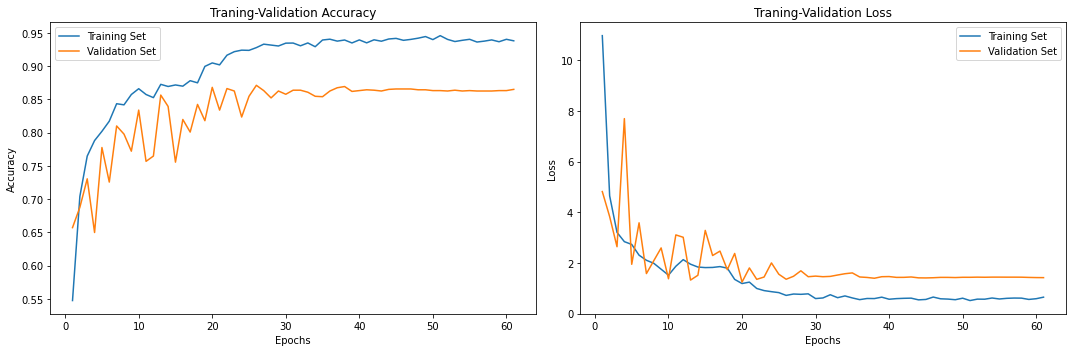

In [22]:
#Plot the results
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize = (15,5))
#accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label = 'Training Set')
plt.plot(epochs_range, val_acc, label = 'Validation Set')
plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Traning-Validation Accuracy')
#loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label = 'Training Set')
plt.plot(epochs_range, val_loss, label = 'Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Traning-Validation Loss')
plt.tight_layout()
plt.show()

# EVALUATION

In [23]:
#Evaluate on training data
train_score = model.evaluate(train_data)
print('Train loss {:.4f}, accuracy {:.2f}%'.format(train_score[0], train_score[1] * 100))

52/52 [==============================] - 57s 1s/step - loss: 0.0115 - accuracy: 0.9974
Train loss 0.0115, accuracy 99.74%


In [24]:
#Evaluate on validation data
val_score = model.evaluate(val_data)
print('Validation loss {:.4f}, accuracy {:.2f}%'.format(val_score[0], val_score[1] * 100))

13/13 [==============================] - 15s 1s/step - loss: 1.4168 - accuracy: 0.8649
Validation loss 1.4168, accuracy 86.49%


In [25]:
#Evaluate on test data
test_score = model.evaluate(test_data)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

32/32 [==============================] - 29s 605ms/step - loss: 1.4316 - accuracy: 0.8524
Test loss 1.4316, accuracy 85.24%


In [26]:
#True and predicted value calculation
class_labels = list(test_data.class_indices.keys())
y_pred = []
y_true = []
ctr = 0
for batch, label in test_data:
    prediction = model.predict(batch).argmax(axis = -1)
    y_pred.extend(prediction)
    y_true.extend(label.argmax(axis = -1))
    ctr += len(prediction)
    if ctr >= len(test_data.labels):
        break

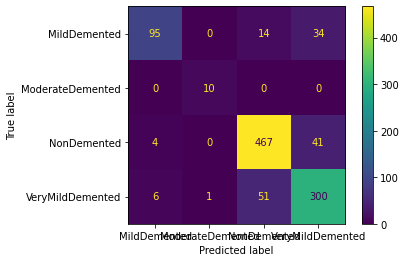

In [27]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels).plot()
plt.show()

In [28]:
#Performance Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print('Accuracy: {:.3f}%'.format(accuracy_score(y_true, y_pred)*100))
print('Precision: {:.3f}%'.format(precision_score(y_true, y_pred, average = 'micro')*100))
print('Recall: {:.3f}%'.format(recall_score(y_true, y_pred, average = 'micro')*100))
print('F1-score: {:.3f}%\n'.format(f1_score(y_true, y_pred, average = 'micro')*100))

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred, target_names = class_labels))

Accuracy: 85.239%
Precision: 85.239%
Recall: 85.239%
F1-score: 85.239%


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.90      0.66      0.77       143
ModerateDemented       0.91      1.00      0.95        10
     NonDemented       0.88      0.91      0.89       512
VeryMildDemented       0.80      0.84      0.82       358

        accuracy                           0.85      1023
       macro avg       0.87      0.85      0.86      1023
    weighted avg       0.85      0.85      0.85      1023

